In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


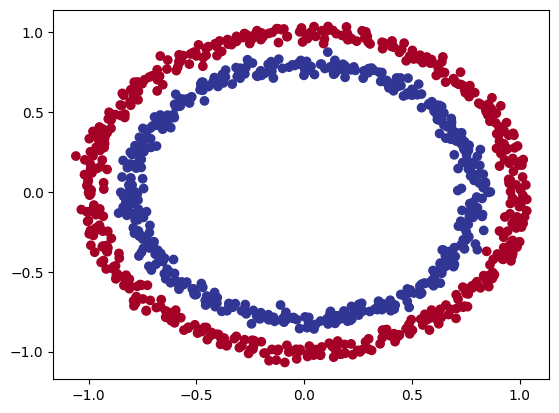

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Turning data into Tensors and splitting it

In [5]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a model

Setting whether to run the code: CPU or GPU

In [7]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear layers capable of handing X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  #3. Create a forwar method containing the forward pass computation
  def forward(self,x):
    #return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2



In [9]:
# Create a target of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1199],
        [ 0.0609],
        [-0.2927],
        [-0.0722],
        [ 0.1857],
        [ 0.2924],
        [ 0.4225],
        [ 0.4779],
        [-0.3126],
        [ 0.0784]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

In [11]:
loss_fn = nn.BCEWithLogitsLoss() #sigmoid built in

#create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

### Let's create an **evauation metric**.

An evaluation metric cab give you another perspective on how your model is going

In [12]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct/len(y_pred))*100

  return acc

### Train Model

#### Building a training and testing loop

In [13]:
torch.manual_seed(42)
epochs=100

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Build training and evaluation loop
for epoch in range(epochs):
  #Train mode
  model_0.train()

  #Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

  #2. calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backwards
  loss.backward()

  #5. optimizer step
  optimizer.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. calculate loss/accu
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70214, Accuracy: 50.38% | Test loss: 0.70808, Test acc: 48.50%
Epoch: 10 | Loss: 0.69986, Accuracy: 51.00% | Test loss: 0.70572, Test acc: 49.00%
Epoch: 20 | Loss: 0.69824, Accuracy: 50.75% | Test loss: 0.70398, Test acc: 49.00%
Epoch: 30 | Loss: 0.69706, Accuracy: 50.75% | Test loss: 0.70266, Test acc: 48.00%
Epoch: 40 | Loss: 0.69619, Accuracy: 51.50% | Test loss: 0.70162, Test acc: 48.50%
Epoch: 50 | Loss: 0.69553, Accuracy: 51.38% | Test loss: 0.70078, Test acc: 48.00%
Epoch: 60 | Loss: 0.69502, Accuracy: 51.50% | Test loss: 0.70010, Test acc: 48.00%
Epoch: 70 | Loss: 0.69463, Accuracy: 51.25% | Test loss: 0.69952, Test acc: 48.00%
Epoch: 80 | Loss: 0.69432, Accuracy: 50.88% | Test loss: 0.69903, Test acc: 48.00%
Epoch: 90 | Loss: 0.69408, Accuracy: 50.75% | Test loss: 0.69861, Test acc: 48.00%


In [14]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

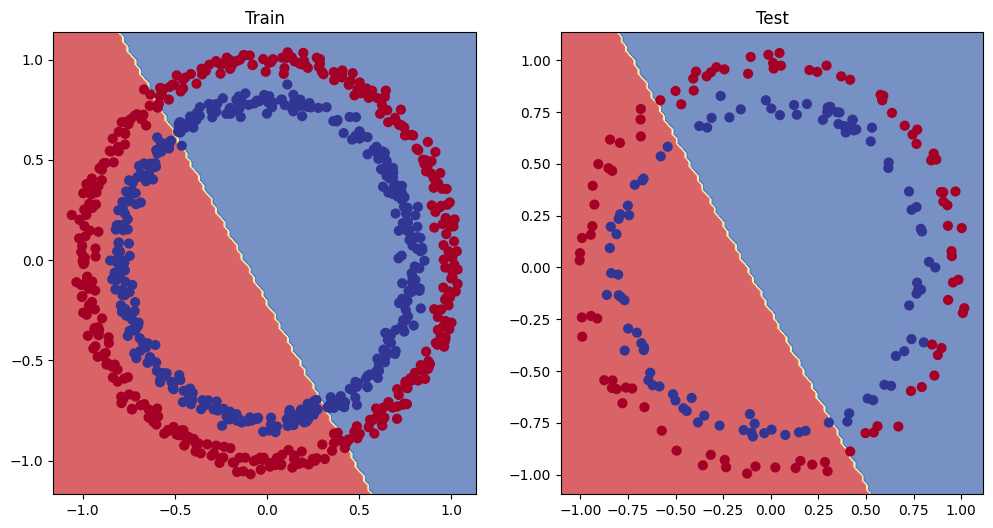

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Let's increase the number of layers and neurons

In [16]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear layers capable of handing X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  #3. Create a forwar method containing the forward pass computation
  def forward(self,x):
    #return the output of layer_2, a single feature, the same shape as y
    return self.layer_3(self.layer_2(self.layer_1(x))) # computation goes through layer_1 first then the output of layer_1 goes through layer_2



In [17]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)


Training the new model

In [19]:
torch.manual_seed(42)

epochs = 10000

#put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  #forward
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  #Optimizer zero grad
  optimizer.zero_grad()

  #loss backwards
  loss.backward()

  #optimizer step
  optimizer.step()

  #Testing phase
  model_1.eval()
  with torch.inference_mode():
    #Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1000 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1100 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc:

Adding nonlinearities

In [20]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #<-- add ReLU in activation function, this add the nonlinearity

  def forward(self,x):
    #Here is how I use the before properties to make the architecture of my Neural Network
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [21]:
model_3 = CircleModelV2().to(device)

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

Training the model

In [24]:
torch.manual_seed(42)
epochs = int(1e3)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate loss and accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  #Optimzer zero grad
  optimizer.zero_grad()

  #Loss backward
  loss.backward()

  #Optimizer step
  optimizer.step()

  ##Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
    # 2. Calcuate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


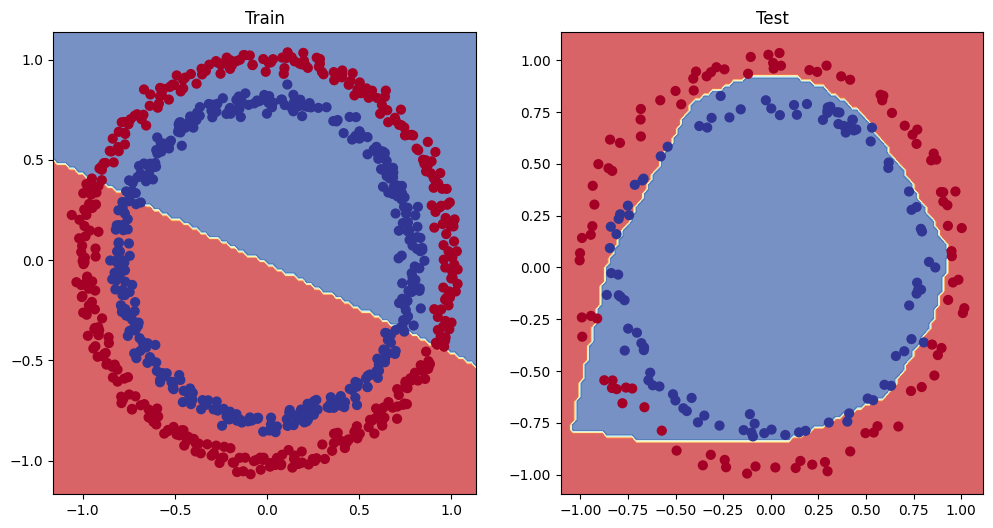

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Let's make a multi-class classification problem

In [27]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

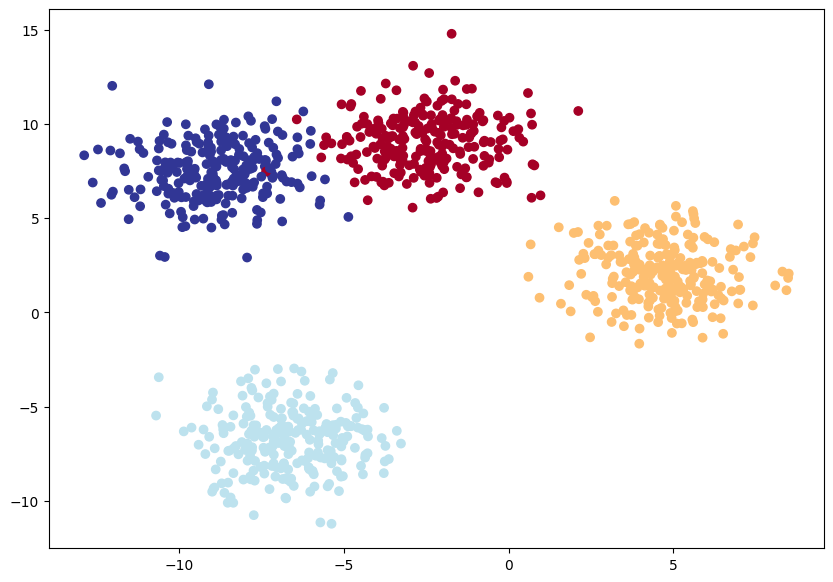

In [49]:
#Set the hyperparameters for the data
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#Create multiclass data
X_blob, y_blob = make_blobs(n_samples = int(1e3),n_features=NUM_FEATURES, centers=NUM_CLASSES,
                            cluster_std = 1.5, random_state= RANDOM_SEED)

#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#Split into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
    )

  def forward(self, x):
        return self.linear_layer_stack(x)

In [44]:
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

Creating loss and optimizer

In [45]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

Training

In [54]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
y_blob_train = y_blob_train.type(torch.LongTensor)
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)

y_blob_test = y_blob_test.type(torch.LongTensor)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.57519, Acc: 95.38% | Test Loss: 0.42672, Test Acc: 97.50%
Epoch: 10 | Loss: 0.13289, Acc: 99.12% | Test Loss: 0.12048, Test Acc: 99.00%
Epoch: 20 | Loss: 0.07753, Acc: 99.12% | Test Loss: 0.06920, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05788, Acc: 99.12% | Test Loss: 0.04999, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04818, Acc: 99.00% | Test Loss: 0.04023, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04249, Acc: 99.00% | Test Loss: 0.03438, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03879, Acc: 99.00% | Test Loss: 0.03051, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03621, Acc: 99.00% | Test Loss: 0.02775, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03431, Acc: 99.12% | Test Loss: 0.02569, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03287, Acc: 99.12% | Test Loss: 0.02409, Test Acc: 99.50%


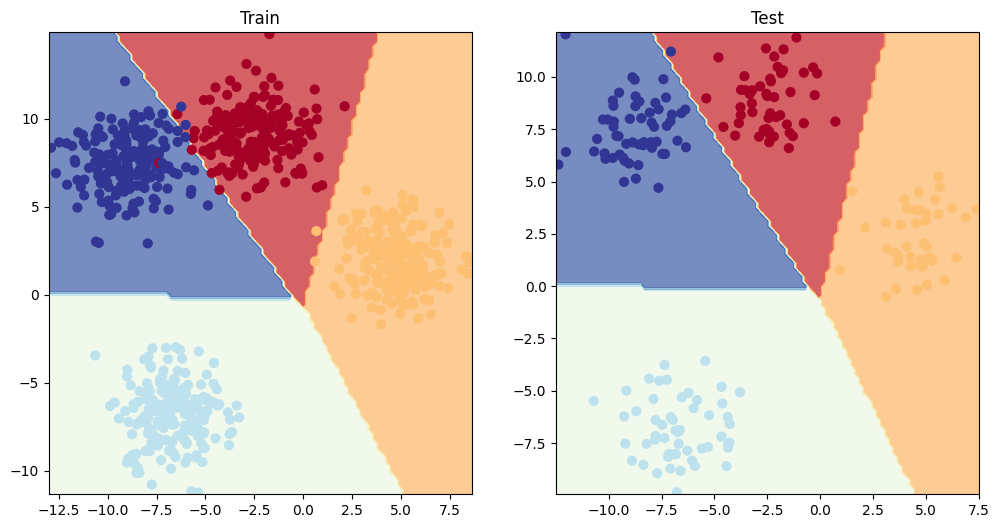

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)